# Installations

# Imports

In [92]:
import io
import os
%matplotlib inline
import matplotlib.pyplot as plt

# data management
import xarray as xr
import numpy as np
import pandas as pd

# Azure Connectivity
import getpass
import azure.storage.blob
from azure.storage.blob import BlobClient

# utilities
import time
import urllib.request
from datetime import datetime


# Code to Generate Average and Record Temperature
* For the specified number of years

### Function to create the empty Results xarray dataset 

In [93]:
def CreateDatasetForResults(filename, start_year, end_year, cmip=6):
    """
    A function that loads the CMIP data file and uses the xarray dataset for reference,
    creates and returns a new xarray with matching dimensions and coordinates but new, empty variables
    The variables of the xarray will be ['tasmaxavg', 'tasmaxrec'] or ['tasminavg', 'tasminrec']
    Similar three dimensions and the coordinates will be there [day: 365, lat: 720,  lon: 1440]
    Input Parameter:
    - filename : a CMIP source data file for createing the reference xarray dataset.
    - start_year : should be the integer value for the intended results date range start (e.g. 1950)
    - end_year : should be the integer value for the intended results date range end (e.g. 1959)
    - cmip        : integer number to specify cmip version (5 or 6 or other). Default is 6    
    Returns: an xarray dataset
    """
    ds_rec = None
    validations_passed = False
    data_type = ''
    
    # validations
    if not (isinstance(start_year, int) and isinstance(end_year, int) and (end_year > start_year)):
        print('Validation Error: start_year and end_year should be integers; end year should be greater than start year.')
    else:
        validations_passed = True
    
    if validations_passed:
        # load the file
        based_on = xr.open_dataset(filename)
        
        var_minmax = list(based_on.data_vars.keys())[0]  # will be tasmax or tasmin
        
        #shape of the dataset
        day_time = based_on.dims.get('time')
        lat = based_on.dims.get('lat')
        lon = based_on.dims.get('lon')
                
        
        if var_minmax == 'tasmax':
            data_type = 'Average and record maximum temperature, based on tasmax'
            ds_variables = ['tasmaxavg', 'tasmaxrec']
            ds_data = {'tasmaxavg' : (['day','lat','lon'], np.empty((day_time, lat, lon))), 'tasmaxrec' : (['day','lat','lon'], np.empty((day_time, lat, lon)))}
        else:
            data_type = 'Average and record minimum temperature, based on tasmin'
            ds_variables = ['tasminavg', 'tasminrec']
            ds_data = {'tasminavg' : (['day','lat','lon'], np.empty((day_time, lat, lon))), 'tasminrec' : (['day','lat','lon'], np.empty((day_time, lat, lon)))}

        ds_rec = based_on.copy(deep = True)   
        ds_rec = ds_rec.rename_dims({'time':'day'})
        ds_rec = ds_rec.assign(ds_data)
        ds_rec = ds_rec.drop_vars(var_minmax)
        ds_rec = ds_rec.assign_coords({"day": xr.DataArray(np.arange(1,366), dims='day')})
        ds_rec = ds_rec.reset_coords('time', drop=True)
        
        n_years = (end_year - start_year) + 1
        
        new_attrs = {'Dataset' : 'Average temperature CMIP{}'.format(cmip),
                     'About dataset' : 'A dataset with average and record temparatures, across years',
                     'Original values' : var_minmax,
                     'Data variables' : ds_variables,
                     'Data description' : data_type,
                     'Range' : str(n_years) + ' years',
                     'Start year' : str(start_year),
                     'End year' : str(end_year),
                     'Years processed' : 0,
                     'Store as' : 'Avg_temp_{}_CMIP{}__{}_yrs__{}_to_{}'.format(var_minmax[-3:]
                                                                               ,cmip
                                                                               ,n_years
                                                                               ,start_year
                                                                               ,end_year)
                    }
        
        ds_rec.attrs = new_attrs
    
    return ds_rec
        


### Function to process each file at a time

In [94]:
def GenerateAverageOneFileAtATime(results, lat_indices, lon_indices, start_year, end_year
    , filename):
    """
    Takes one file at a time and updates the average, peak values in the existing 'results' dataset.
    Average and Record temperatures are captured for each cell, i.e. the lat, lon combination in the specified grid.
    The units of temperature (degree Kelvin) are preserved.
    Input Parameters:
    - results     : xarray dataset with average, record temperature for 365 days
    - lat_indices : applicable index values for latitudes. If None, will calculate for the complete grid
    - lon_indices : applicable index values for longitudes. If None, will calculate for the complete grid.
    - start_year  : start year of the range
    - end_year    : end year of the range
    - filename    : name of the .nc file to process
    Returns:  None. The input xarray dataframe 'results' is updated.
    """
    # load the file
    print(filename)
    xds = xr.open_dataset(filename)
    
    if not (lat_indices is None or lon_indices is None):
        # take applicabel subset of lat and lon
        xds = xds[dict(lat=lat_indices,lon=lon_indices)]
    
    # print("xds", xds)     ## For debugging
    
    # max or min
    var_minmax = list(xds.data_vars.keys())[0]  # will be tasmax or tasmin
        
    # note the variable names in the results dataset
    result_variables = results.attrs['Data variables']

    new_values = xds[var_minmax][:].to_numpy()

    n_years = results.attrs['Years processed']
    
    # if first year in the range
    if n_years == 0:
        results.update({result_variables[0] : (['day','lat','lon'], new_values)       # avg temperature
                        , result_variables[1] : (['day','lat','lon'], new_values)})   # record temperature        
    else:
        if var_minmax == "tasmin":        
            results.update({result_variables[1] : xr.ufuncs.minimum(new_values
                                                                    , results[result_variables[1]])})   # peak min temperature across years
        else:
            results.update({result_variables[1] : xr.ufuncs.maximum(new_values
                                                                    , results[result_variables[1]])})   # peak max temperature across years
        # for both max and min
        results.update({result_variables[0] : np.round((((results[result_variables[0]] * n_years) + new_values) / (n_years+1)),2)})  # avg across years
        results.update({result_variables[1] : np.round(results[result_variables[1]], 2)})  # round off only
        
    
    # in any case...
    n_years += 1
    results.attrs['Years processed'] = n_years


### Function to download a specified file

In [95]:
def download_file(sas_url, filename, overwrite_local_file, from_azure=False):
    """
    Downloads the specified file from the internet -- and if specified, from Azure blob storage
    If asked to not overwrite, then first checks if the file is available locally and does not download again in that case.
    - sas_url   : url complete with sas token
    - filename  : name of the downloaded file
    - overwrite_local_file : if True, will overwrite, else, if already available locally, will not download again.
    - from_azure: default False. if True, will download from the azure blob storage
    Returns:  None
    """
    print("downloading {}, from_azure {}".format(filename, from_azure))
    if overwrite_local_file or not (os.path.isfile(filename)):
        if from_azure: 
            blob_client = BlobClient.from_blob_url(sas_url)
            with open(filename, "wb") as my_blob:
                download_stream = blob_client.download_blob()
                my_blob.write(download_stream.readall())
        else:
            with open(filename, "wb") as dnld_file:                
                with urllib.request.urlopen(sas_url) as f:                    
                    dnld_file.write(f.read())


### Function to prepare the average for the desired range of years

In [96]:
def PrepareAverageForRange(filename_prefix, lat_indices, lon_indices, start_year, end_year, cmip=6
                           , url_prefix=None, sas_token=None, from_azure=False
                           , overwrite_local_file=False, remove_after_use=True):
    """
    Prepares a results dataset then runs in a loop for the specified range of years:
    * downloads the file for each year, if url_prefix is set else no download, file will expected to be available locally      
    * and calls the function that processes data one file at time.
    * then deletes the file
    Note: if url from azure or other location requiring access token, then provide the SAS token as well
    Average and Record temperatures are captured for each cell, i.e. the lat, lon combination in the specified grid.
    The units of temperature (degree Kelvin) are preserved.
    Input Parameters:
    - filename_prefix  : initial part of the filename. Year will be appended to it, along with file extension '.nc'
    - lat_indices : applicable index values for latitudes. If None, will calculate for the complete grid
    - lon_indices : applicable index values for longitudes. If None, will calculate for the complete grid.
    - start_year  : start year of the range
    - end_year    : end year of the range
    - cmip        : integer number to specify cmip version (5 or 6 or other). Default is 6
    - url_prefix  : url to files location, without the filename
                  : for Azure blob storage, specify the url with the container and the folder location
    - sas_token   : A sas token with 'read' permissions to the azure blob container
    - from_azure  : default is False. Set to True if downloading from Azure blob storage
    - overwrite_local_file  : if True, will overwrite, else, if already available locally, will not download again.
    - remove_after_use      : default = True. Set to False to retain the files locally
    Returns:  The xarray dataframe with 'results'
    """
    validations_passed = False
    ds_results = None
    filename = ''
    
    # validations
    if not (isinstance(start_year, int) and isinstance(end_year, int) and (end_year > start_year)):
        print('Validation Error: start_year and end_year should be integers; end year should be greater than start year.')
    else:
        validations_passed = True
    
    if validations_passed:               
        total_years = 0        
            
        # prepare to time the operation
        start_time = time.time()
        for yr in range(start_year, (end_year + 1)):
            print(yr)
            filename = filename_prefix + str(yr) + '.nc'
            
            # if required, download the file so it is available locally
            if not url_prefix is None:
                sas_url = os.path.join(url_prefix, filename) # add filename to the url prefix
                if sas_token is not None:
                    sas_url = sas_url + "?" + sas_token            # add token, if provided
                download_file(sas_url, filename, overwrite_local_file, from_azure)
            
            # first prepare results dataset
            if total_years == 0:
                ds_results = CreateDatasetForResults(filename = filename, start_year = start_year, end_year = end_year
                                                     , cmip=cmip)

            # process the file
            GenerateAverageOneFileAtATime(ds_results, lat_indices, lon_indices, start_year, end_year
                                          , filename)
            total_years += 1
            
            # delete the file
            if remove_after_use:
                os.remove(filename)
            
        # print out the time it took
        execution_time = (time.time() - start_time)
        print("Complete execution time | PrepareAverageForRange | (mins) {:0.2f}".format(execution_time/60.0))
            
    return ds_results

### Function to save the Results file in Azure blob

In [97]:
def SaveResult(results, azure_url_prefix = None, sas_token=None, local_copy=True):
    """
    Create a NetCDF4 file from the xarrary dataset 'results'. Prompts for sas token if pushing to Azure Blob Storage.
    Input parameters:
    - results   :
    - azure_url_prefix : if uploading to blob, this will be the url to the container and the folder 
    - sas_token : if uploading to blob, a sas token with 'write' permissions to the azure blob container
    - local_copy: By default, True, i.e. local_copy will be retained. Setting to False will remove file only 
                  after upload to Azure Blob Storage
    Returns: string. The name of the newly created file.
    """
    # determine the name of the file
    filename = results.attrs['Store as'] + '.nc'
    
    # a local copy will initially be saved, in any case
    results.to_netcdf(filename, mode='w', format='NETCDF4')

    # if required to upload to Azure blob storage
    if not azure_url_prefix is None:
        # prepare to time the operation
        start_time = time.time()
        
        # Create a blob client using the local file name as the name for the blob
        sas_url = os.path.join(azure_url_prefix, filename) # add filename to the url prefix
        sas_url = sas_url + "?" + sas_token
        blob_client = BlobClient.from_blob_url(sas_url)

        # Upload the created file
        with open(filename, "rb") as data:
            blob_client.upload_blob(data)

        # if asked to not retain the local copy after use, then delete the file
        if local_copy == False:
            os.remove(filename)
            
        # print out the time it took
        execution_time = (time.time() - start_time)
        print("Complete execution time | SaveResult | (mins) {:0.2f}".format(execution_time/60.0))
    
    return filename

### Execute for the desired range of years -- downloading from Azure Blob Storage:

In [119]:
# name_prefix = 'tasmin_day_BCSD_historical_r1i1p1_inmcm4_'                # without the year at the end
# url_prefix = 'https://nexdcp30.blob.core.windows.net/cmip5/historical/'  # without the name of the file at the end
# start_year = 1950
# end_year = 1959

# sas_token = getpass.getpass()  # prompts for sas token

# ds_results = PrepareAverageForRange(filename_prefix = name_prefix, lat_indices = None, lon_indices = None
#                                     , start_year = start_year, end_year = end_year, cmip=5
#                                    , azure_url_prefix=url_prefix, sas_token=sas_token, from_azure=True
#                                    , overwrite_local_file=False, remove_after_use=True)
# ds_results

 ··············································································································································


1950
tasmin_day_BCSD_historical_r1i1p1_inmcm4_1950.nc
1951
tasmin_day_BCSD_historical_r1i1p1_inmcm4_1951.nc
1952
tasmin_day_BCSD_historical_r1i1p1_inmcm4_1952.nc
1953
tasmin_day_BCSD_historical_r1i1p1_inmcm4_1953.nc
1954
tasmin_day_BCSD_historical_r1i1p1_inmcm4_1954.nc
1955
tasmin_day_BCSD_historical_r1i1p1_inmcm4_1955.nc
1956
tasmin_day_BCSD_historical_r1i1p1_inmcm4_1956.nc
1957
tasmin_day_BCSD_historical_r1i1p1_inmcm4_1957.nc
1958
tasmin_day_BCSD_historical_r1i1p1_inmcm4_1958.nc
1959
tasmin_day_BCSD_historical_r1i1p1_inmcm4_1959.nc
Complete execution time | PrepareAverageForRange | (mins) 5.71


<xarray.Dataset>
Dimensions:    (lat: 720, lon: 1440, day: 365)
Coordinates:
  * lat        (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon        (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * day        (day) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
Data variables:
    tasminavg  (day, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    tasminrec  (day, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Dataset:           Average temperature CMIP5
    About dataset:     A dataset with average and record temparatures, across...
    Original values:   tasmin
    Data variables:    ['tasminavg', 'tasminrec']
    Data description:  Average and record minimum temperature, based on tasmin
    Range:             10 years
    Start year:        1950
    End year:          1959
    Years processed:   10
    Store as:          Avg_temp_min_CMIP5__10_yrs__1950_to_1959

In [27]:
# tfname = 'tasmax_day_GISS-E2-1-G_historical_r1i1p1f2_gn_1950.nc'
# try_ds = xr.open_dataset(tfname)
# try_ds

<xarray.Dataset>
Dimensions:  (time: 365, lat: 600, lon: 1440)
Coordinates:
  * time     (time) object 1950-01-01 12:00:00 ... 1950-12-31 12:00:00
  * lat      (lat) float64 -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    tasmax   (time, lat, lon) float32 ...
Attributes: (12/20)
    activity:            NEX-GDDP-CMIP6
    contact:             Dr. Rama Nemani: rama.nemani@nasa.gov, Dr. Bridget T...
    Conventions:         CF-1.7
    creation_date:       2021-09-20T17:30:11.016689+00:00
    frequency:           day
    institution:         NASA Earth Exchange, NASA Ames Research Center, Moff...
    ...                  ...
    tracking_id:         09687121-d128-4b85-bc08-d773540ebfab
    title:               GISS-E2-1-G, r1i1p1f2, historical, global downscaled...
    resolution_id:       0.25 degree
    history:             2021-09-20T17:30:11.016689+00:00: install global att...
    disclaimer:          This data is considered provisional and subject to c...
    external_variables:  areacella

In [37]:
try_ds.dims.get('time')

365

### Execute for the desired range of years -- downloading from NASA site:

In [50]:
### Uncomment and run only if required

# name_prefix = 'tasmax_day_GISS-E2-1-G_historical_r1i1p1f2_gn_'               # without the year at the end

# # url_prefix: remeber to update to tasmax or tasmin; provide without the filename
# url_prefix = 'https://data.nas.nasa.gov/viz/vizdata/armichae/gddp/GISS-E2-1-G/historical/r1i1p1f2/tasmax/'

# start_year = 2000
# end_year = 2009

# # sas_token = getpass.getpass()  # prompts for sas token
# sas_token = None  # not required for downloading from NASA 

# # cmip 6 this time!
# ds_results = PrepareAverageForRange(filename_prefix = name_prefix, lat_indices = None, lon_indices = None
#                                     , start_year = start_year, end_year = end_year, cmip=6
#                                    , url_prefix=url_prefix, sas_token=sas_token, from_azure=False
#                                    , overwrite_local_file=False, remove_after_use=True)
# ds_results

2000
tasmax_day_GISS-E2-1-G_historical_r1i1p1f2_gn_2000.nc
2001
tasmax_day_GISS-E2-1-G_historical_r1i1p1f2_gn_2001.nc
2002
tasmax_day_GISS-E2-1-G_historical_r1i1p1f2_gn_2002.nc
2003
tasmax_day_GISS-E2-1-G_historical_r1i1p1f2_gn_2003.nc
2004
tasmax_day_GISS-E2-1-G_historical_r1i1p1f2_gn_2004.nc
2005
tasmax_day_GISS-E2-1-G_historical_r1i1p1f2_gn_2005.nc
2006
tasmax_day_GISS-E2-1-G_historical_r1i1p1f2_gn_2006.nc
2007
tasmax_day_GISS-E2-1-G_historical_r1i1p1f2_gn_2007.nc
2008
tasmax_day_GISS-E2-1-G_historical_r1i1p1f2_gn_2008.nc
2009
tasmax_day_GISS-E2-1-G_historical_r1i1p1f2_gn_2009.nc
Complete execution time | PrepareAverageForRange | (mins) 4.20


<xarray.Dataset>
Dimensions:    (lat: 600, lon: 1440, day: 365)
Coordinates:
  * lat        (lat) float64 -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
  * lon        (lon) float64 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * day        (day) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
Data variables:
    tasmaxavg  (day, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    tasmaxrec  (day, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Dataset:           Average temperature CMIP6
    About dataset:     A dataset with average and record temparatures, across...
    Original values:   tasmax
    Data variables:    ['tasmaxavg', 'tasmaxrec']
    Data description:  Average and record maximum temperature, based on tasmax
    Range:             10 years
    Start year:        2000
    End year:          2009
    Years processed:   10
    Store as:          Avg_temp_max_CMIP6__10_yrs__2000_to_2009

### Save results and upload to Azure blob

In [51]:
### Uncomment and run only if required

# # cmip5
# # url_prefix = 'https://nexdcp30.blob.core.windows.net/cmip5/averages/'  # without the name of the file at the end
# # cmip6
# url_prefix = 'https://nexdcp30.blob.core.windows.net/cmip6/averages/'  # without the name of the file at the end

# if sas_token is None:
#     sas_token = getpass.getpass()  # prompts for sas token

# filename = SaveResult(ds_results, url_prefix, sas_token, local_copy=False)
# filename

 ·········································································································································


Complete execution time | SaveResult | (mins) 1.10


'Avg_temp_max_CMIP6__10_yrs__2000_to_2009.nc'

In [10]:
### Uncomment and run only if required

# filename = 'Avg_temp_max_CMIP5__10_yrs__1980_to_1989.nc'
# newds = xr.open_dataset(filename)
# newds

<xarray.Dataset>
Dimensions:    (lat: 720, lon: 1440, day: 365)
Coordinates:
  * lat        (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon        (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * day        (day) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
Data variables:
    tasmaxavg  (day, lat, lon) float32 ...
    tasmaxrec  (day, lat, lon) float32 ...
Attributes:
    Dataset:           Average temperature CMIP5
    About dataset:     A dataset with average and record temparatures, across...
    Original values:   tasmax
    Data variables:    ['tasmaxavg', 'tasmaxrec']
    Data description:  Average and record maximum temperature, based on tasmax
    Range:             10 years
    Start year:        1980
    End year:          1989
    Years processed:   10
    Store as:          Avg_temp_max_CMIP5__10_yrs__1980_to_1989

### Function to aggregate average results from multiple pre-processed results

In [98]:
def AggregateAverageForRange(start_year, end_year, cmip=6, result_type='max'
                           , azure_url_prefix=None, sas_token=None
                           , overwrite_local_file=False, remove_after_use=True):
    """
    Makes available Average and Record temperatures for multiple decades. 
    * Date range should be a multiple of decades --- e.g. 1950 to 1969  OR 1951 to 1970.
    * Make sure the underlying data files, by decades are available. Else, an exception will be raised!
    
    Checks the preprocessed average data files in Azure cloud or locally and:
    * downloads the matching file if already exists
    * else, checks for the component files (by decade). 
    * -- If complete data not available, exception is thrown. Else, the required files are downloaded and aggregated.
    * returns the results xarray dataset
    Average and Record temperatures are captured for each cell, i.e. the lat, lon combination in the specified grid.
    The units of temperature (degree Kelvin) are preserved.
    Input Parameters:
    - start_year  : start year of the range
    - end_year    : end year of the range
    - cmip        : integer number to specify cmip version (5 or 6 or other). Default is 6
    - result_type : string 'max' or 'min'
    - azure_url_prefix=None : if downloading from Azure blob storage, specify the url with the container and the folder
                              , else specify None to check the files locally.
    - sas_token   : A sas token with 'read' permissions to the azure blob container
    - overwrite_local_file  : if True, will overwrite, else, if already available locally, will not download again.
    - remove_after_use      : default = True. Set to False to retain the files locally
    Returns:  The xarray dataframe with 'results'
    """
    validations_passed = False
    ds_results = None
    filename = ''
    
    n_years = (end_year - start_year) + 1   # range
    
    # validations
    if not (isinstance(start_year, int) and isinstance(end_year, int) and (end_year > start_year)):
        print('Validation Error: start_year and end_year should be integers; end year should be greater than start year.')
    elif not (n_years)%10 == 0:
        print('Validation Error: The total range (end year - start year)+1 should be a multiple of 10.')    
    else:
        validations_passed = True
    
    if validations_passed:
        n_components = int(n_years / 10)             # number of decades in the range       
        total_years = 0                    
        
        # intended filename
        filename = 'Avg_temp_{}_CMIP{}__{}_yrs__{}_to_{}.nc'.format(result_type
                                                                 ,cmip
                                                                 ,n_years
                                                                 ,start_year
                                                                 ,end_year)
        # intended component filenames
        component_files = [''] * n_components   # as many component files as many decades in the range
        component_available = [False] * n_components   # initialized as none of the files are available
        complete_data = False                   # initialized as file / components are not available
        
        component_start_year = start_year  
        for i in range(n_components):
            component_end_year = component_start_year + 9
            component_files[i] = 'Avg_temp_{}_CMIP{}__{}_yrs__{}_to_{}.nc'.format(result_type
                                                                 ,cmip,10,component_start_year,component_end_year)
            component_start_year += 10

        # prepare to time the operation
        start_time = time.time()
        
        # if local storage is to be checked first
        if azure_url_prefix is None or overwrite_local_file==False:
            if os.path.exists(filename):                # if the complete file exists
                complete_data = True                
            else:
                # check each file exists
                for i in range(n_components):
                    component_available[i] = os.path.exists(component_files[i])
                    
                complete_data = all(component_available)

        # if complete data is not available locally, check if we can look in Azure blob storage
        if not complete_data:
            if azure_url_prefix is not None:
                # check in azure
                # first the complete file...
                sas_url = azure_url_prefix + filename + "?" + sas_token
                blob_client = BlobClient.from_blob_url(sas_url)
                if blob_client.exists():
                    download_file(sas_url, filename, overwrite_local_file, from_azure=True)
                    complete_data = True
                else:
                    for i in range(n_components):
                        # only for files not availble locally, unless overwrite_local_file = True
                        if not component_available[i] or overwrite_local_file:
                            sas_url = azure_url_prefix + component_files[i] + "?" + sas_token
                            blob_client = BlobClient.from_blob_url(sas_url)
                            if blob_client.exists():
                                download_file(sas_url, component_files[i], overwrite_local_file, from_azure=True)
                            else:
                                errMsg = 'Missing component file (on Azure){}'.format(component_available[i])
                                raise ValueError(errMsg)
                    complete_data = True    

                
            else: 
                errMsg = 'Missing component files (locally): {}'.format(', '.join([str(component_files[i]) for i,bv in enumerate(component_available) if bv]))
                raise ValueError(errMsg)


        # complete files should be available locally at this stage
        # start by checking for the complete file first
        if os.path.exists(filename):
            ds_results = xr.open_dataset(filename)  # load the complete file directly
            total_year = n_years
            # delete the file
            if remove_after_use:
                os.remove(filename)
        else:
            # prepare from component files            
            for cfilename in component_files:
                if total_years == 0:    # first file
                    ds_results = xr.open_dataset(cfilename)                    
                else:
                    ds_comp = xr.open_dataset(cfilename)
                    result_variables = ds_results.attrs['Data variables']
                    if remove_after_use:
                        os.remove(cfilename)
                    if result_type == "min":        
                        ds_results.update({result_variables[1] : xr.ufuncs.minimum(ds_comp[result_variables[1]]
                                                                                , ds_results[result_variables[1]])})   # peak min temperature across years
                    else:
                        ds_results.update({result_variables[1] : xr.ufuncs.maximum(ds_comp[result_variables[1]]
                                                                                , ds_results[result_variables[1]])})   # peak max temperature across years
                    # for both max and min
                    ds_results.update({result_variables[0] : (ds_results[result_variables[0]] + ds_comp[result_variables[1]])})    # sum across years
                # in any case    
                total_years += 10
            # finally, for avg from component files        
            ds_results.update({result_variables[0] : np.round((ds_results[result_variables[0]] / n_components), 2)})    # avg across years
            ds_results.update({result_variables[1] : np.round(ds_results[result_variables[1]], 2)})    # round off values

        # set attributes
        ds_results.attrs['Range'] = str(n_years) + ' years'
        ds_results.attrs['Start year'] = str(start_year)
        ds_results.attrs['End year'] = str(end_year)
        ds_results.attrs['Years processed'] = total_years
        ds_results.attrs['Store as'] = 'Avg_temp_{}_CMIP{}__{}_yrs__{}_to_{}'.format(result_type
                                                                               ,cmip, n_years, start_year, end_year)
            
        # print out the time it took
        execution_time = (time.time() - start_time)
        print("Complete execution time | AggregateAverageForRange | (mins) {:0.2f}".format(execution_time/60.0))
            
    return ds_results

### Call Aggregate Results to get a range of multiple decades

In [54]:
### Uncomment and run only if required

# # configure first
# cmip = 6              # 5 or 6 or other
# result_type = 'max'   # max or min

# url_prefix = 'https://nexdcp30.blob.core.windows.net/cmip{}/averages/'.format(cmip)  # without the name of the file at the end

# ds_results = AggregateAverageForRange(1950, 1979, cmip=cmip, result_type=result_type
#                            , azure_url_prefix=url_prefix, sas_token=sas_token
#                            , overwrite_local_file=False, remove_after_use=True)

Complete execution time | AggregateAverageForRange | (mins) 3.73


In [55]:
ds_results

<xarray.Dataset>
Dimensions:    (lat: 600, lon: 1440, day: 365)
Coordinates:
  * lat        (lat) float64 -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
  * lon        (lon) float64 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * day        (day) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
Data variables:
    tasmaxavg  (day, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    tasmaxrec  (day, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Dataset:           Average temperature CMIP6
    About dataset:     A dataset with average and record temparatures, across...
    Original values:   tasmax
    Data variables:    ['tasmaxavg', 'tasmaxrec']
    Data description:  Average and record maximum temperature, based on tasmax
    Range:             30 years
    Start year:        1950
    End year:          1979
    Years processed:   30
    Store as:          Avg_temp_max_CMIP6__30_yrs__1950_to_1979

### Save aggregate results dataset and upload to Azure blob

In [56]:
### Uncomment and run only if required

# cmip = 6              # 5 or 6 or other
# url_prefix = 'https://nexdcp30.blob.core.windows.net/cmip{}/averages/'.format(cmip)  # without the name of the file at the end

# filename = SaveResult(ds_results, url_prefix, sas_token, local_copy=True)
# filename

Complete execution time | SaveResult | (mins) 1.44


'Avg_temp_max_CMIP6__30_yrs__1950_to_1979.nc'

In [117]:
# ds_results['tasminavg'][0][549][1]

<xarray.DataArray 'tasminavg' ()>
array(268.82, dtype=float32)
Coordinates:
    lat      float32 47.38
    lon      float32 0.375
    day      int64 1

In [105]:
# ds_results['tasmaxrec'][0][549][1]

<xarray.DataArray 'tasmaxrec' ()>
array(286.24, dtype=float32)
Coordinates:
    lat      float32 47.38
    lon      float32 0.375
    day      int64 1

# Interactive function to get Average data and the plot

## Helper functions to the main Interactive function(s)

In [2]:
# validations for Interactive_GetAverageForRange()
def Validations_for_Interactive_GetAverageForRange(start_year, end_year, n_years, save_back_in_azure, azure_url_prefix, sas_token):
    """
    Performs validations applicable to the function Interactive_GetAverageForRange.    
    Returns: Boolean. True if validations pass. Else returns False.
    """
    validations_passed = False
    if not (isinstance(start_year, int) and isinstance(end_year, int) and (end_year > start_year)):
        print('Validation Error: start_year and end_year should be integers; end year should be greater than start year.')
    elif not (n_years)%10 == 0:
        print('Validation Error: The total range (end year - start year)+1 should be a multiple of 10.')    
    elif (save_back_in_azure == True) and (azure_url_prefix is None or sas_token is None) :
        print('Validation Error: Both azure_url_prefix and sas_token are to be provided if save_back_in_Azure = True.')    
    else:
        validations_passed = True
    
    return validations_passed

In [3]:
# create SAS url -- for Interactive_GetAverageForRange()
def create_sas_url(azure_url_prefix, sas_token, filename):
    """
    Creates the URL complete with Azure container, folder, filename + azure security access token (sas). 
    Used in Interactive_GetAverageForRange.    
    Returns: String. sas_url.
    """
    sas_url = os.path.join(azure_url_prefix, filename)  # add filename to the url prefix
    return sas_url + "?" + sas_token

In [4]:
# upload local files to Azure -- for Interactive_GetAverageForRange()
def upload_averages_file_to_Azure(save_back_in_azure, sas_url, filename):
    """
    Uploads locally generated files of Averages to Azure. Used in Interactive_GetAverageForRange.    
    prints out statuses.
    Returns: None.
    """
    if save_back_in_azure and sas_url is not None:
        print("{} UTC: Save back in Azure = True. Upload averages file if not in Azure already".format(datetime.now().strftime("%H:%M:%S")))
        blob_client = BlobClient.from_blob_url(sas_url)
        if blob_client.exists():
            print("{} UTC: Averages file {} is already in Azure. Not uploading again.".format(datetime.now().strftime("%H:%M:%S"), filename))                    
        else:
            # Upload the created file
            print("{} UTC: Averages file {} not in Azure already. Uploading now...".format(datetime.now().strftime("%H:%M:%S"), filename))
            with open(filename, "rb") as data:
                blob_client.upload_blob(data)
            print("{} UTC: Averages file {} successfully uploaded.".format(datetime.now().strftime("%H:%M:%S"), filename))

In [5]:
# check if file available in Azure -- for Interactive_GetAverageForRange()
def is_file_in_Azure(sas_url):
    """
    Checks if the specified file is in Azure. Used in Interactive_GetAverageForRange.    
    Returns: Boolean. True if file is available. Else, False
    """        
    blob_client = BlobClient.from_blob_url(sas_url)
    return True if blob_client.exists() else False

In [6]:
# download file from Azure -- for Interactive_GetAverageForRange()
def download_file_from_Azure(sas_url, filename):
    """
    Downloads file from Azure. Used in Interactive_GetAverageForRange.    
    Returns: None.
    """
    if save_back_in_azure and sas_url is not None:
        blob_client = BlobClient.from_blob_url(sas_url)
        if blob_client.exists():
            print("{} UTC: Averages file {} is already in Azure. Not uploading again.".format(datetime.now().strftime("%H:%M:%S"), filename))                    
        else:
            # Upload the created file
            print("{} UTC: Averages file {} not in Azure already. Uploading now...".format(datetime.now().strftime("%H:%M:%S"), filename))
            with open(filename, "rb") as data:
                blob_client.upload_blob(data)
            print("{} UTC: Averages file {} successfully uploaded.".format(datetime.now().strftime("%H:%M:%S"), filename))

In [101]:
# prepare component files -- for Interactive_GetAverageForRange()
def prepare_component_averages_files(save_back_in_azure, azure_url_prefix, sas_token, result_type, cmip
                                     , start_year, n_years, cmip_files_url, cmip_file_name_prefix, from_azure):
    """
    For the given range, prepares component (10-year) averages files. 
    Checks if available locally, or in Azure. Else prepares it.
    Uploads to azure if save_back_in_azure = True, and not already there.
    This helper function also gets used by Interactive_GetAverageForRange()
    Returns: None
    """
    n_components = int(n_years / 10)
    component_start_year = start_year
    
    print("{} UTC: Arranging for all the component (10-year) files(s)".format(datetime.now().strftime("%H:%M:%S")))
    
    for i in range(n_components):
        component_end_year = component_start_year + 9
        filename = 'Avg_temp_{}_CMIP{}__{}_yrs__{}_to_{}.nc'.format(result_type,cmip,10,component_start_year,component_end_year)
        if azure_url_prefix is not None: 
            sas_url = create_sas_url(azure_url_prefix, sas_token, filename)
        else:
            sas_url = None
        
        print("{} UTC: Component file {} of {} : --- {} to {} ----------".format(datetime.now().strftime("%H:%M:%S")
                                                                            , i+1, n_components, component_start_year, component_end_year))
        
                
        local = os.path.exists(filename)    # first, check if available locally
        print("{} UTC: Component file available locally? {}".format(datetime.now().strftime("%H:%M:%S"), 'Yes' if local else 'No. Checking in Azure...'))
        
        if local:
            upload_averages_file_to_Azure(save_back_in_azure, sas_url, filename)  # upload, if required            
        else:
            if is_file_in_Azure(sas_url):
                print("{} UTC: Component file available in Azure, downloading...".format(datetime.now().strftime("%H:%M:%S")))
                download_file(sas_url, filename, overwrite_local_file=True, from_azure=True)
                print("{} UTC: Download complete".format(datetime.now().strftime("%H:%M:%S")))
            else:
                print("{} UTC: Component file also not in Azure, preparing...".format(datetime.now().strftime("%H:%M:%S")))
                ds_results = PrepareAverageForRange(filename_prefix = cmip_file_name_prefix, lat_indices = None, lon_indices = None
                                                    , start_year = component_start_year, end_year = component_end_year, cmip= cmip
                                                   , url_prefix=cmip_files_url, sas_token=sas_token, from_azure=from_azure
                                                   , overwrite_local_file=False, remove_after_use=True)
                if ds_results is None:
                    raise ValueError('Error! Component file could not be prepared. Check parameters')
                
                if save_back_in_azure:
                    SaveResult(ds_results, azure_url_prefix, sas_token, local_copy=True)
                else:
                    SaveResult(ds_results, azure_url_prefix=None, sas_token=None, local_copy=True)
                
        component_start_year += 10
        print("{} UTC: All the component (10-year) files(s) are now available".format(datetime.now().strftime("%H:%M:%S")))
    

## Main Interactive function(s)

In [108]:
def Interactive_GetAverageForRange(start_year, end_year, cmip=6, result_type='max'
                            , azure_url_prefix=None, sas_token=None
                            , cmip_files_url=None, cmip_file_name_prefix=None, from_azure=False
                            , save_back_in_azure=False):
    """
    Makes available Average and Record temperatures for multiple decades. 
    * Date range should be a multiple of decades --- e.g. 1950 to 1969  OR 1951 to 1970.
    Checks if the preprocessed average data files are already available locally. 
    If not found, checks in Azure cloud. 
    If not found in Azure as well, tries to prepare the output from the available underlying 10 year files, in azure.
    If underlying 10 year files are also not there then tries to create those as well.
    In that case, checks for underlying source CMIP data files based on the url provided.
    All the files not found in Azure are attempted to be saved there, if azure_url_prefix is provided 
    and save_back_in_azure = True.
    
    * returns the results xarray dataset
    Average and Record temperatures are captured for each cell, i.e. the lat, lon combination in the specified grid.
    The units of temperature (degree Kelvin) are preserved.
    Input Parameters:
    - start_year  : start year of the range
    - end_year    : end year of the range
    - cmip        : integer number to specify cmip version (5 or 6 or other). Default is 6
    - result_type : string 'max' or 'min'
    - azure_url_prefix=None : if downloading from Azure blob storage, specify the url with the container and the folder
                              , else specify None to check the files locally.
    - sas_token   : A sas token with 'read' permissions to the azure blob container    
    - cmip_files_url: Underlying cmip files could be at a different path in azure, or elsewhere.
    - cmip_file_name_prefix: Name of the underlying cmip files, without the year. E.g. 'tasmin_day_BCSD_historical_r1i1p1_inmcm4_'
    - from_azure  : True, if the cmip files path is of azure. In that case sas_token will be used to read/write files.
    - save_back_in_azure: If true, the final file
   Returns:  The xarray dataframe with 'results'
    """
    validations_passed = False
    ds_results = None
    filename = ''
    sas_url = None
    
    n_years = (end_year - start_year) + 1   # range
    
    # proceed if validations pass
    validations_passed = Validations_for_Interactive_GetAverageForRange(start_year, end_year, n_years
                                                                        , save_back_in_azure, azure_url_prefix, sas_token)
    
    if validations_passed:
        n_components = int(n_years / 10)             # number of decades in the range       
        total_years = 0   
        
        print('Get Average and Record {} temperature for the range {} to {}, for CMIP{}'.format(result_type, start_year, end_year, cmip))
        ans = input('Do you want to continue? y/n').lower()
        
        if not ans == 'y':
            print("Response: {}.\n Not 'y', stopping execution.".format(ans))        
            return None
        
        start_time = time.time()        # prepare to time the operation        
        filename = 'Avg_temp_{}_CMIP{}__{}_yrs__{}_to_{}.nc'.format(result_type, cmip, n_years, start_year, end_year)                
        print("{} UTC: Get Averages file {}".format(datetime.now().strftime("%H:%M:%S"), filename))
        
        if azure_url_prefix is not None: 
            sas_url = create_sas_url(azure_url_prefix, sas_token, filename)
        
        local = os.path.exists(filename)    # first, check if available locally
        print("{} UTC: Available locally? {}".format(datetime.now().strftime("%H:%M:%S"), 'Yes' if local else 'No. Checking in Azure...'))
        
        if local:
            upload_averages_file_to_Azure(save_back_in_azure, sas_url, filename)  # upload, if required
            ds_results = xr.open_dataset(filename)                                # open file        
        else:
            if is_file_in_Azure(sas_url):
                print("{} UTC: Available in Azure {}, downloading...".format(datetime.now().strftime("%H:%M:%S"), filename))
                download_file(sas_url, filename, overwrite_local_file=True, from_azure=True)
                print("{} UTC: Download complete".format(datetime.now().strftime("%H:%M:%S")))
                ds_results = xr.open_dataset(filename)
            else:
                print("{} UTC: Also not in Azure {}, preparing...".format(datetime.now().strftime("%H:%M:%S"), filename))
                prepare_component_averages_files(save_back_in_azure, azure_url_prefix, sas_token, result_type, cmip
                                                 , start_year, n_years, cmip_files_url, cmip_file_name_prefix, from_azure)
            
                print("{} UTC: Aggregate 10-year files into full range...".format(datetime.now().strftime("%H:%M:%S")))
                ds_results = AggregateAverageForRange(start_year, end_year, cmip, result_type
                           , azure_url_prefix, sas_token
                           , overwrite_local_file=False, remove_after_use=False)
                
                if save_back_in_azure:
                    print("{} UTC: Dataset ready, saving locally and in Azure...".format(datetime.now().strftime("%H:%M:%S"), filename))                
                    SaveResult(ds_results, azure_url_prefix, sas_token, local_copy=True)
                else:
                    print("{} UTC: Dataset ready, saving locally...".format(datetime.now().strftime("%H:%M:%S"), filename))                
                    SaveResult(ds_results, azure_url_prefix=None, sas_token=None, local_copy=True)
        
         # print out the time it took
        execution_time = (time.time() - start_time)
        print("Complete execution time | Interactive_GetAverageForRange | (mins) {:0.2f}".format(execution_time/60.0))
        
        return ds_results
        
       

## Plot for a given latitude and longitude

In [161]:
def plot_avg_and_record_temperatures(ds_record, latitude, longitude):
    """
    Pass in the dataset and the latitude, longitude.
    Algorithm will find the nearest matching latitude and longitude in the grid.
    Will show plot for the same.
    Returns: None
    """
    fig, ax = plt.subplots()

    fig.set_size_inches(12, 8)

    ds = ds_record.sel(lat=[latitude], lon=[longitude], method="nearest")

    x = ds.get('day')

    pmax = ds['tasmaxrec'].squeeze()
    ax.plot(x, pmax, color='lightgray', alpha=0.9, label='Average Temperature')

    amax = ds['tasmaxavg'].squeeze()
    ax.plot(x, amax, color='gray', alpha=0.6, label='Maximum Temperature')
    
    ax.set_title('Avg and Record Max Temperature - {} to {}'.format(ds_record.attrs['Start year'], ds_record.attrs['End year']))
    ax.set_xlabel('Day')
    ax.set_ylabel('Temperature in Degrees Kelvin')
    
    ax.legend()
    plt.show()

## Call the Interactive_GetAverageForRange() function

In [109]:
start_year = 1950
end_year = 1979

# averages file in azure
use_sas_token = 'sp=racwdl&st=2021-09-30T01:25:57Z&se=2021-10-01T01:25:57Z&spr=https&sv=2020-08-04&sr=c&sig=YBQnRKTMRODBj1gIDDMtbSAw8aEEPlbs%2BjBLRy5q8eY%3D'
use_azure_url = 'https://precapstone.blob.core.windows.net/cmip6/averages'

# cmip files - raw data from NASA site
name_prefix = 'tasmax_day_GISS-E2-1-G_historical_r1i1p1f2_gn_'               # without the year at the end
# url_prefix: remeber to update to tasmax or tasmin; provide without the filename
cmip_files_url = 'https://data.nas.nasa.gov/viz/vizdata/armichae/gddp/GISS-E2-1-G/historical/r1i1p1f2/tasmax/'
                
ret_ds = Interactive_GetAverageForRange(start_year, end_year, cmip=6, result_type='max'
                           , azure_url_prefix=use_azure_url, sas_token=use_sas_token
                           , cmip_files_url=cmip_files_url, cmip_file_name_prefix=name_prefix, from_azure=False
                           , save_back_in_azure=True)
ret_ds

Get Average and Record max temperature for the range 1950 to 1979, for CMIP6


Do you want to continue? y/n y


00:06:17 UTC: Get Averages file Avg_temp_max_CMIP6__30_yrs__1950_to_1979.nc
00:06:17 UTC: Available locally? Yes
00:06:17 UTC: Save back in Azure = True. Upload averages file if not in Azure already
00:06:17 UTC: Averages file Avg_temp_max_CMIP6__30_yrs__1950_to_1979.nc is already in Azure. Not uploading again.
Complete execution time | Interactive_GetAverageForRange | (mins) 0.01


<xarray.Dataset>
Dimensions:    (lat: 600, lon: 1440, day: 365)
Coordinates:
  * lat        (lat) float64 -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
  * lon        (lon) float64 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * day        (day) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
Data variables:
    tasmaxavg  (day, lat, lon) float32 ...
    tasmaxrec  (day, lat, lon) float32 ...
Attributes:
    Dataset:           Average temperature CMIP6
    About dataset:     A dataset with average and record temparatures, across...
    Original values:   tasmax
    Data variables:    ['tasmaxavg', 'tasmaxrec']
    Data description:  Average and record maximum temperature, based on tasmax
    Range:             30 years
    Start year:        1950
    End year:          1979
    Years processed:   30
    Store as:          Avg_temp_max_CMIP6__30_yrs__1950_to_1979

### Plot the results

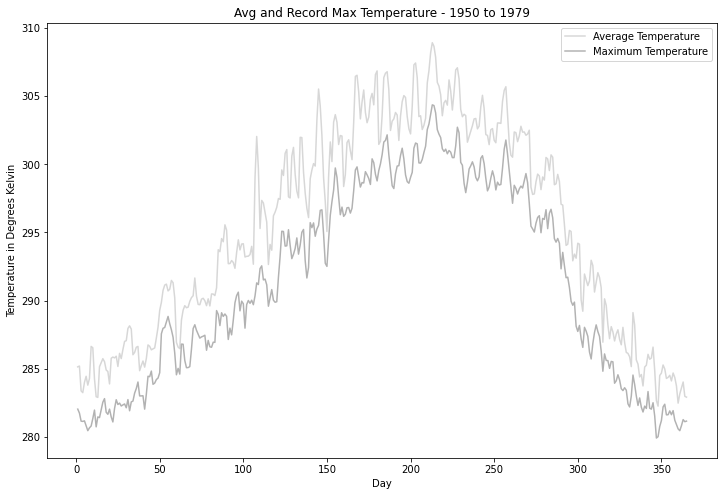

In [162]:
plot_avg_and_record_temperatures(ret_ds, latitude=47.2, longitude=238)